# Binary Logistic Regression trained with Pytorch

Binary Logistic Regression is a method used for binary classification tasks. When implemented in PyTorch, it involves setting up a model with a linear layer and a sigmoid activation function to predict probabilities. The model is trained using binary cross-entropy loss and optimizers like SGD or Adam, leveraging PyTorch's auto-differentiation and GPU acceleration for efficient training.

## The MNIST dataset


The MNIST dataset is a large collection of handwritten digits commonly used for training various image processing systems. It contains 70,000 images of digits from 0 to 9, split into a training set of 60,000 images and a test set of 10,000 images.

![MNIST dataset](./images/mnist.png "MNIST dataset")

## Install packages

In [1]:
!pip install torch-summary

## Importing the required packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from typing import Tuple
from torchvision import datasets, transforms
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.1  Device: cuda


## Dataset preparation: Dataset class

In Pytorch, the data set is made available through a `Dataset` class. We will make an implementation of the `MNISTDataset` class to read from the CSV files located in the ./data directory.

Trebuie sa urmam pasii:
1. Our `MNISTDataset' class will derive from the `torch.utils.data.Dataset' class. The `__init__` method will receive the location of the input CSV file. For the binary regression, you will also receive the numbers for which you want to build a binary classifier.
1. In addition to the `__init__` method, we will have two more implemented methods:
    1. the `__len__` method that returns the number of elements in the data set
    1. the `__getitem__` method that returns the specified index value. By value, for this problem, we mean the tuple: input vector of 784 components and label (1 = positive class, 0 = negative class)

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str, positive_class: int, negative_class: int):
        """
        Initializes the dataset using a path to a CSV file and specifies the positive and negative classes.
        :param path_csv: Path to the CSV file containing training or testing data.
        :param positive_class: Index of the positive class, a number from 0 to 9.
        :param negative_class: Index of the negative class, a number from 0 to 9, different from positive_class.
        """
        # It's customary to call the parent class initializer in a derived class
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'The path {path_csv} does not lead to a file'
        assert 0 <= positive_class <= 9 and 0 <= negative_class <= 9 and positive_class != negative_class
        self.path_csv = path_csv
        
        _all_digits = pd.read_csv(path_csv, header=None).values
        # Inputs in x, labels in y
        _y = _all_digits[:, 0]
        _x = _all_digits[:, 1:]
        # Scale the 0..255 values in the input set _x to 0..1
        _x = _x / 255

        # Find indices where the labels are either positive_class or negative_class
        _mask_pos_neg = np.logical_or(_y == positive_class, _y == negative_class)
        # Keep only positive and negative cases
        self.x = _x[_mask_pos_neg]
        self.y = _y[_mask_pos_neg]

        self.y[self.y == positive_class] = 1
        self.y[self.y == negative_class] = 0
        
        # Convert from numpy arrays to torch tensors:
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)
        
    def __len__(self):
        """
        Returns the length of the current dataset.
        :return: Length of the dataset.
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the tuple (input, associated_label) at the given index.
        :param index: The position from which the vector and its class are returned.
        :return: Pair: input vector of 784 elements, class label 0 or 1.
        """
        return self.x[index, :], self.y[index]

In [4]:
positive_class = 8
negative_class = 4
train_ds = MNISTDataset('../data/mnist_train.csv', positive_class, negative_class)
test_ds = MNISTDataset('../data/mnist_test.csv', positive_class, negative_class)

assert len(train_ds) == 11693
assert len(test_ds) == 1956

## Loading data using a DataLoader

A Dataset object gives access to the values in a set, element by element. For training, the grouping of several data is preferred, to make the calculation more efficient. A group of data is called a minibatch. Data grouping in minibatches is done by a DataLoader. It receives parameters such as:
* the dataset object from which it takes the data
* minibatch size
* if random mixing of the data set is desired

Sometimes the data sets are small enough to be loaded into the GPU memory, for gradient calculation. Many times, however, the sets are too large and then it is preferable to divide them into data subsets (minibatches). Below we use minibatches of 32 data, value specified in `batch_size` parameters.

In [5]:
batch_size = 32  # Depending on the available GPU memory
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# For the first minibatch, print the 'shape'
# The input data should be a tensor of shape (batch_size x 784)
# The labels should be a tensor of shape batch_size
for data, label in train_loader:
    print(data.shape, label.shape)
    break

torch.Size([32, 784]) torch.Size([32])


## Model definition

In Pytorch a model is a class derived from `torch.nn.Module'. Essential are the implementation of:
* initialization method, `__init__`
* the `forward` method that takes a mini batch of input and produces an estimate

The initialization method builds the weights.

In [6]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784):
        """
        Initializes a Logistic Regression object.
        :param input_size: The size of an input vector. For example, for MNIST it is 784.
        """
        # It's customary to call the parent class initializer in a derived class
        super(BinaryLogisticRegression, self).__init__()
        self.input_size = input_size
        # Initialize weights as a matrix of input_size x 1 random elements
        # Matrix = linear operator
        self.fully_connected = nn.Linear(input_size, 1)

    def forward(self, x):
        # x is a minibatch of examples with the shape 32x784 (the last minibatch may have fewer than 32 tensors)

        # Propagation from the input layer to the first hidden layer
        # Applying a linear function is equivalent to multiplying a matrix with the current input
        x = self.fully_connected(x)
        # Apply the logistic sigmoid function to obtain the conditional probability
        x = torch.sigmoid(x)
        return x

Instantiate the model:

In [7]:
model = BinaryLogisticRegression(input_size=784)

Print the model:

In [8]:
print(model)

BinaryLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=1, bias=True)
)


More details can be found with the `summary()` function:

In [9]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            785
Total params: 785
Trainable params: 785
Non-trainable params: 0


We pass the model to the device. If device=cpu, then the line below has no effect. If device=cuda, then the model is passed to the GPU and the run will be faster:

In [10]:
print(f'device={device}')
model.to(device)

device=cuda


BinaryLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=1, bias=True)
)

## Short demo: what does the model predict for the first minibatch in the training set?

In [11]:
for x, y in train_loader:
    # The data and the model must be on the same device; otherwise, calculations cannot be performed
    x, y = x.to(device), y.to(device)
    
    # Produces the prediction, a tensor filled with probabilities
    y_hat = model(x).squeeze()
    print(f'Predictions (probabilities): {y_hat}')
    
    # If the conditional probability is >= 0.5, then the model predicts the positive class (1); otherwise, 0
    classes = y_hat >= 0.5
    # Classes is a boolean vector; True = 1, False = 0
    print('How many classes were predicted correctly: ', (classes == y).sum())
    
    # We stop after the first minibatch here, just to see how the predictions made by the model look
    break

Predictions (probabilities): tensor([0.5173, 0.5534, 0.5179, 0.5308, 0.4824, 0.5146, 0.5444, 0.5176, 0.4797,
        0.5219, 0.5234, 0.5421, 0.5087, 0.4957, 0.4997, 0.4753, 0.4985, 0.5573,
        0.5331, 0.4690, 0.4968, 0.5007, 0.4768, 0.5174, 0.5858, 0.5649, 0.5588,
        0.5403, 0.5133, 0.5324, 0.5362, 0.5122], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
How many classes were predicted correctly:  tensor(12, device='cuda:0')


## Model Training

We will have several training epochs. In each era:
* all the minibatches of data in train_loader are traversed
* the minibatch error function is calculated, the gradients are calculated, the gradients are applied to change the weights
* at the end of each epoch, the model is run on the test set, to see the accuracy obtained

In [12]:
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Test the model on the data provided by the loader.
    :param model: binary logistic regression model
    :param loader: a dataloader providing the data from the dataset being tested
    :param device: the device on which the model is located (cpu, gpu, tpu, etc.)
    :return: prediction accuracy
    """
    # initialize values for statistics
    correctly_classified = 0
    total_items = 0
    # when testing, the model does not learn anymore. It is explicitly set to evaluation mode.
    model.eval()
    # disable automatic tracking of tensors for which gradients can be calculated:
    # gradients are only used for training, not for testing
    with torch.no_grad():
        for x, y in loader:
            # move the data from the test set to the same device as the model
            x, y = x.to(device), y.to(device)
            
            # the model predicts the conditional probabilities for the current minibatch
            y_hat = model(x).squeeze()
            
            # the prediction is the positive class if the probability is >=0.5, otherwise negative class
            predicted_class = y_hat >= 0.5
            
            correctly_classified += torch.sum(predicted_class == y)
            total_items += len(x)
    accuracy = correctly_classified / total_items
    return accuracy.cpu().detach().item()

The accuracy of the untrained model on the test set is:

In [13]:
acc = test(model, test_loader, device)
print(f'Accuracy of the untrained model: {acc * 100}%')

Accuracy of the untrained model: 43.047034740448%


Optimizer instance. We use a Stochastic Gradient Descent algorithm, with weight decay (equivalent to L2 regularization):

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

The error function is binary cross entropy:

In [15]:
# loss function
loss_fn = torch.nn.BCELoss()

In [16]:
# the number of epochs
epochs = 30

In [17]:
losses = []
accuracies = []
for epoch in range(epochs):
    # The model needs to be set to train mode before training.
    # Switching to eval mode occurs when calling the test() method.
    model.train()
    epoch_loss = 0
    total_items = 0
    for x, y in train_loader:
        # Move the data from the training set to the same device as the model.
        x, y = x.to(device), y.to(device)
        
        # Clear previously calculated gradients; otherwise, there will be accumulation of gradients - not of interest for this model.
        optimizer.zero_grad()
        
        # The model predicts the conditional probabilities for the current minibatch.
        y_hat = torch.squeeze(model(x))
        
        # Calculate the loss function for the current minibatch.
        loss = loss_fn(y_hat, y)
        # The calculated loss is the average loss value over the current minibatch;
        # multiply the average by the number of values in the minibatch to determine the cumulative loss value over the minibatch.
        epoch_loss += loss.item() * len(x)
        # Update the total number of items for which training is performed.
        total_items += len(x)
        
        # Request gradient computation.
        loss.backward()
        
        # The optimizer applies the gradients to the weights = learning.
        optimizer.step()
    
    epoch_loss /= total_items
    losses.append(epoch_loss)
    # Print statistics.
    print(f'Epoch: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')
    acc_test = test(model, test_loader, device)
    accuracies.append(acc_test)
    print(f'Epoch: {epoch + 1}/{epochs}: accuracy on test set = {acc_test * 100:.4f}%\n')

Epoch: 1/30: loss = 0.2515407
Epoch: 1/30: accuracy on test set = 98.1084%

Epoch: 2/30: loss = 0.1137806
Epoch: 2/30: accuracy on test set = 98.3129%

Epoch: 3/30: loss = 0.0873160
Epoch: 3/30: accuracy on test set = 98.5174%

Epoch: 4/30: loss = 0.0744389
Epoch: 4/30: accuracy on test set = 98.7219%

Epoch: 5/30: loss = 0.0664248
Epoch: 5/30: accuracy on test set = 98.9264%

Epoch: 6/30: loss = 0.0609038
Epoch: 6/30: accuracy on test set = 98.9775%

Epoch: 7/30: loss = 0.0568006
Epoch: 7/30: accuracy on test set = 98.9264%

Epoch: 8/30: loss = 0.0535913
Epoch: 8/30: accuracy on test set = 98.9775%

Epoch: 9/30: loss = 0.0509767
Epoch: 9/30: accuracy on test set = 99.0286%

Epoch: 10/30: loss = 0.0488193
Epoch: 10/30: accuracy on test set = 99.0286%

Epoch: 11/30: loss = 0.0469888
Epoch: 11/30: accuracy on test set = 99.1309%

Epoch: 12/30: loss = 0.0454034
Epoch: 12/30: accuracy on test set = 99.1309%

Epoch: 13/30: loss = 0.0440224
Epoch: 13/30: accuracy on test set = 99.0798%

Epoc

## Binary Logistic Regression evolution graphs

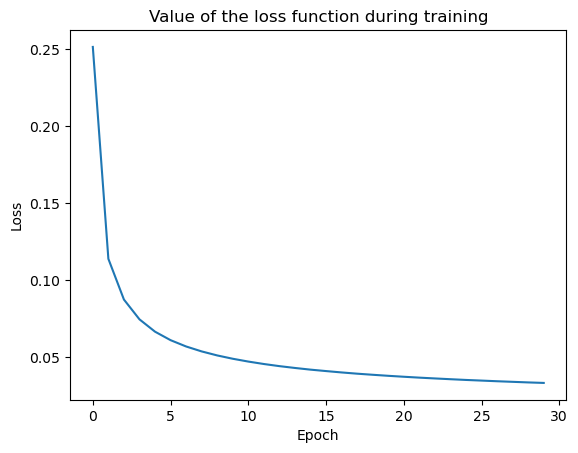

In [18]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Value of the loss function during training')
plt.show()

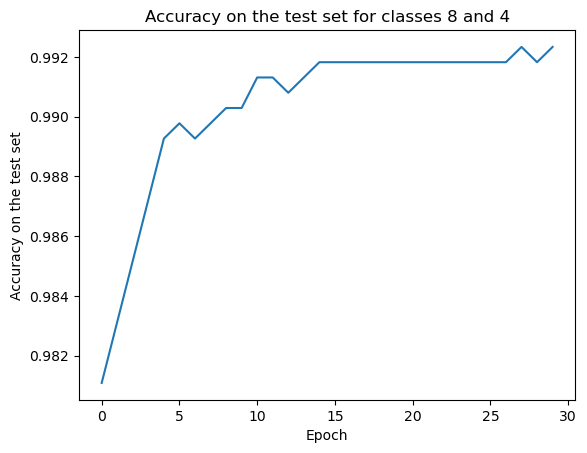

In [19]:
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy on the test set')
plt.title(f'Accuracy on the test set for classes {positive_class} and {negative_class}')
plt.show()